# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [1]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [2]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return (np.linalg.norm((X @ w) - y) ** 2) / len(y)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 * (X.T @ ((X @ w) - y)) / len(y)

In [4]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    res = np.array([w_init.copy()])
    for _ in range(n_iterations):
        w_init = w_init - lr * loss.calc_grad(X, y, w_init)
        res = np.vstack((res, w_init.copy()))
    return res


Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045028
0.8670644395649502


In [8]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

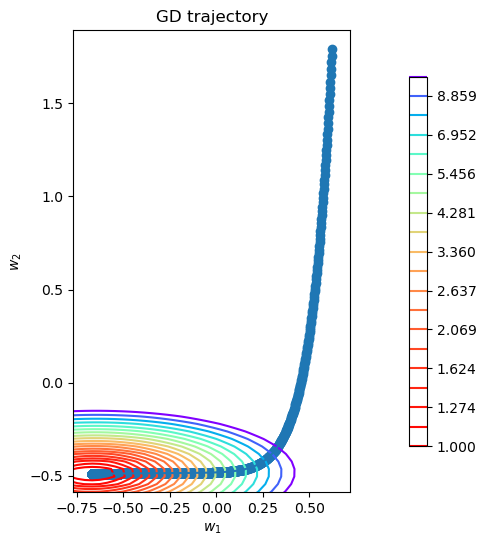

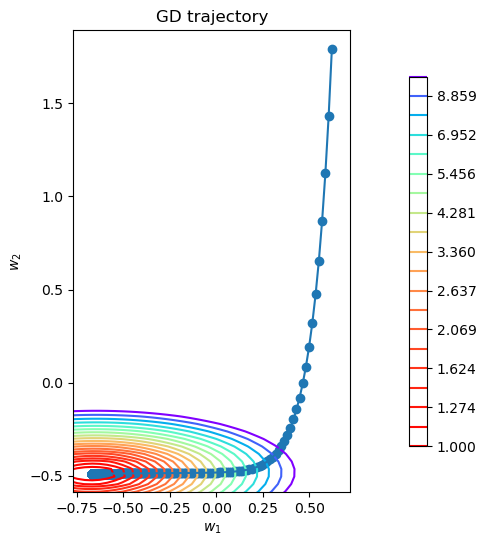

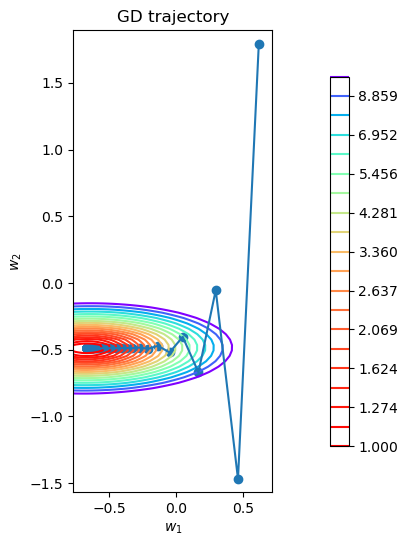

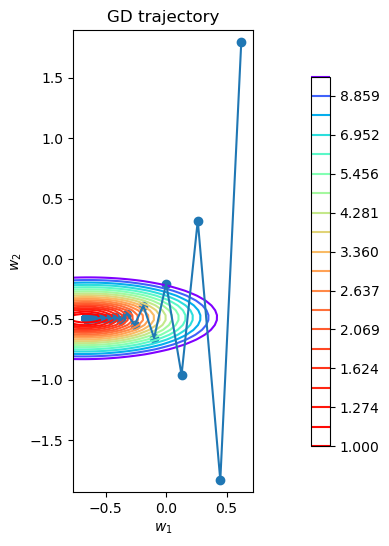

In [9]:
loss = MSELoss()
for lr in [0.0001, 0.001, 0.009, 0.01]:
    w_list = gradient_descent(w_init, X, y, loss, lr, 10000)
    plot_gd(w_list, X, y, loss)

learning rate отвечает за скорость оптимизации и за результирующую точность. Слишком много -- плохо, как и слишком мало тоже.

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    res = np.array([w_init.copy()])
    for _ in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init = w_init - lr * loss.calc_grad(X_batch, y_batch, w_init)
        res = np.vstack((res, w_init.copy()))
    return res

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

lr: 0.0001


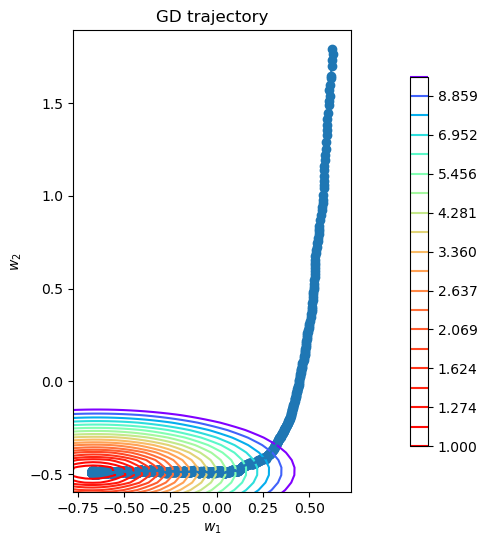

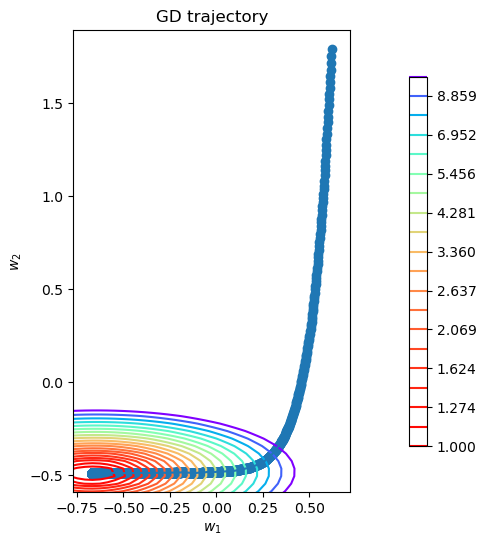

lr: 0.001


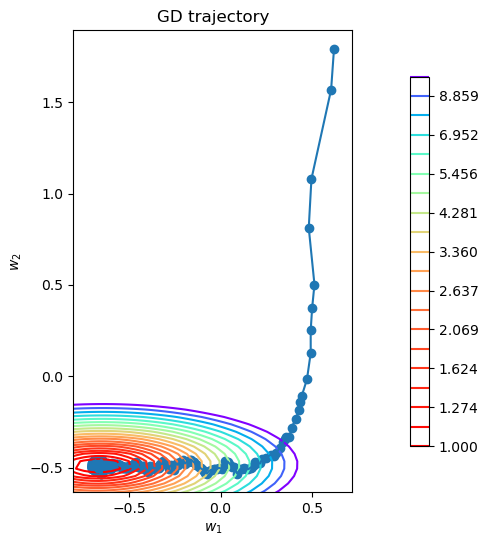

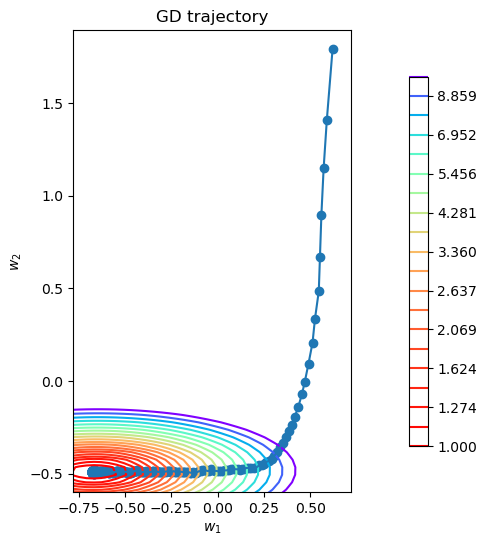

lr: 0.009


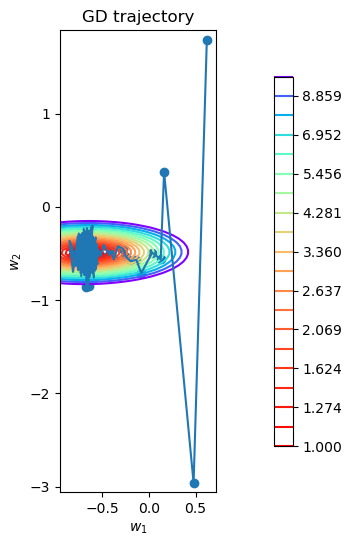

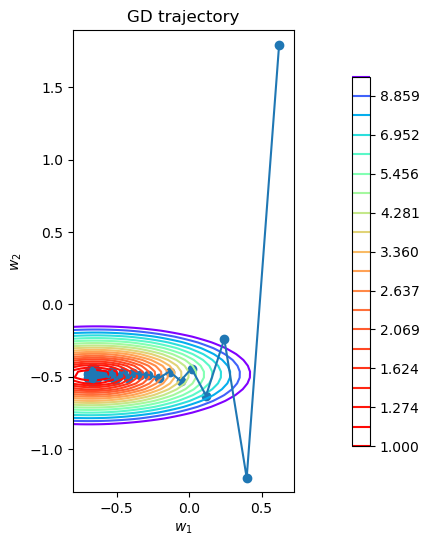

lr: 0.01


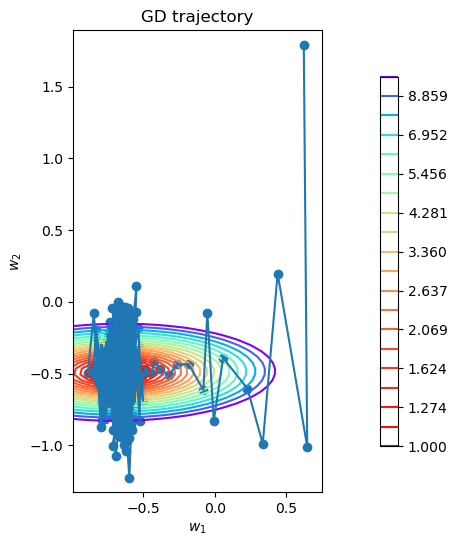

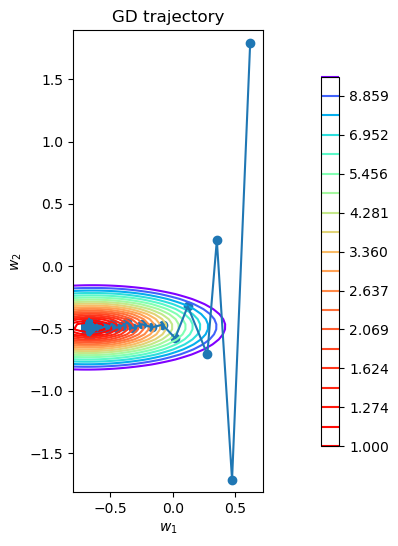

In [11]:
loss = MSELoss()
for lr in [0.0001, 0.001, 0.009, 0.01]:
    print("lr:", lr)
    for size in [10, 100]:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, size, 10000)
        plot_gd(w_list, X, y, loss)

Стохастический градиентный спуск более шумный, он больше колеблется, однако работает быстрее. Чем меньше значений в батче, тем больше его может кидать туда сюда. lr влияет так же, как и на обычный GD.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    res = np.array([w_init.copy()])
    for t in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init = w_init - (lr * (1 / ((1 + t) ** p))) * loss.calc_grad(X_batch, y_batch, w_init)
        res = np.vstack((res, w_init.copy()))
    return res

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

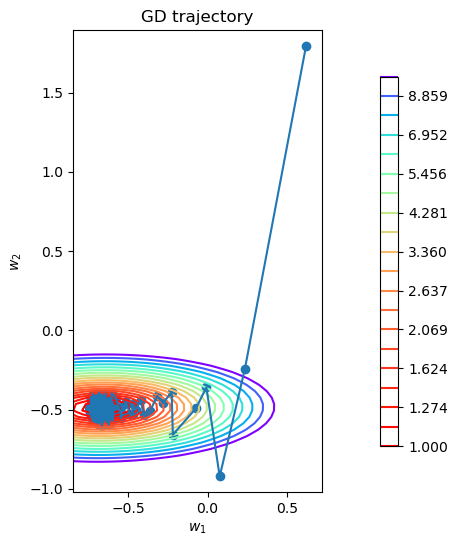

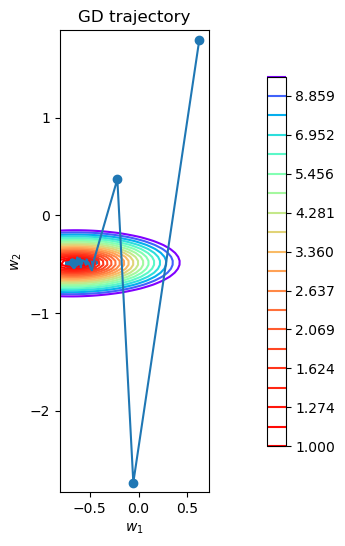

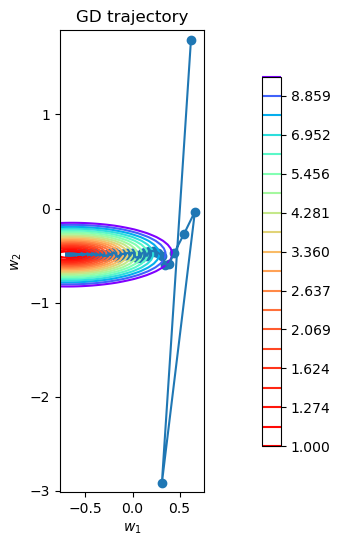

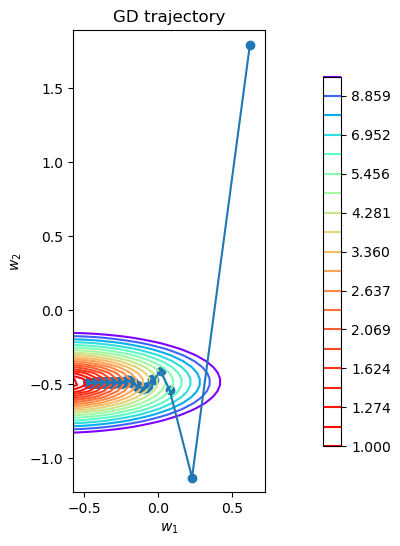

In [13]:
loss = MSELoss()
for p in [0.1, 0.3, 0.7, 1]:
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, 0.01, 10, p, 10000)
    plot_gd(w_list, X, y, loss)

p влияет на затухание градиента, из-за чего первый-второй шаги очень большие, но потом становятся меньше. Это позволяет ускорить работу (при правильном подборе p), ведь градиент будет быстрее подбираться к оптимуму засчёт рывков вначале.

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

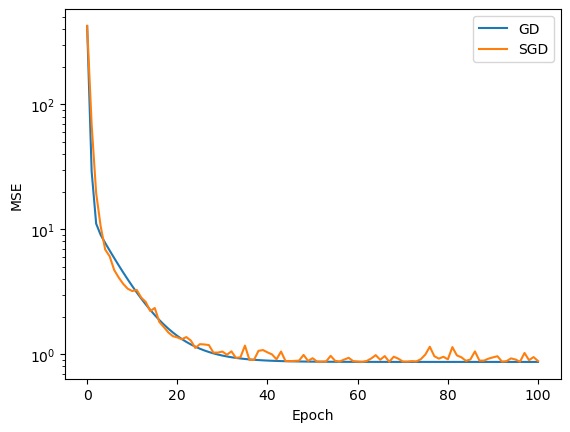

In [14]:
w_list_gd = gradient_descent(w_init, X, y, loss, 0.005, 100)
w_list_sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.005, 10, 100)

gd_losses = [loss.calc_loss(X, y, w) for w in w_list_gd]
sgd_losses = [loss.calc_loss(X, y, w) for w in w_list_sgd]

plt.plot(gd_losses, label="GD")
plt.plot(sgd_losses, label="SGD")

plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.yscale('log')
plt.legend()

plt.show()

SGD, хоть и более шумный, работает примерно так же, как и обычный GD, однако имеет важное преимущество в виде ускорения работы. Таким образом получаем одни плюсы; SGD работает быстрее, при том качество практически не страдает

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        if np.any(X[:, 0] != np.ones(X.shape[0])):
            ones_col = np.ones((X.shape[0], 1))
            X = np.hstack((ones_col, X))

        w = np.zeros(X.shape[1])
        self.w = gradient_descent(w, X, y, self.loss, self.lr, 10000)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.asarray(X)
        if np.any(X[:, 0] != np.ones(X.shape[0])):
            ones_col = np.ones((X.shape[0], 1))
            X = np.hstack((ones_col, X))
        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [18]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [20]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       164 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       199 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      197 non-null    float64
 20  19      197 non-null    float64
 21  20      201 non-null    float64
 22  21

In [21]:
X_raw.drop(columns=["index"], inplace=True)

In [22]:
numeric_features = X_raw.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_raw.select_dtypes(include=['object']).columns

In [23]:
X_raw[cat_features] = X_raw[cat_features].fillna("Unknown")

In [24]:
X_raw[numeric_features] = X_raw[numeric_features].fillna(X_raw[numeric_features].mean())

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_raw[numeric_features] = scaler.fit_transform(X_raw[numeric_features])

In [26]:
X_raw = pd.get_dummies(X_raw, columns=cat_features)

In [27]:
X_raw.columns = X_raw.columns.astype(str)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, shuffle=True)

Обучите линейную регрессию на обучающей выборке

In [30]:
linear_regression.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [31]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    ss_res = np.sum((y_true - y_predicted) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [32]:
print(f"r2 score train: {r2(y_train, linear_regression.predict(X_train))}")
print(f"r2 score test: {r2(y_test, linear_regression.predict(X_test))}")

r2 score train: 0.9728773038079324
r2 score test: 0.9169286365690354


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: Нет, не надо. Он не зависит от параметров объектов, поэтому не подвержен переобучению, нам не нужно его "ужимать".

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [33]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return (np.linalg.norm((X @ w) - y) ** 2) / len(y) + self.coef * (np.linalg.norm(np.hstack((0, w[1:])) ** 2))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 * (X.T @ ((X @ w) - y)) / len(y) + 2 * self.coef * np.hstack((0, w[1:]))

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [34]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [35]:
linear_regression.fit(X_train, y_train)

In [36]:
print(f"r2 score train: {r2(y_train, linear_regression.predict(X_train))}")
print(f"r2 score test: {r2(y_test, linear_regression.predict(X_test))}")

r2 score train: 0.9154570084891499
r2 score test: 0.851601760975314


In [37]:
best_model = None
max_r2 = 0
for lambdaa in [0.01, 0.1, 0.5, 1]:
    linear_regression = LinearRegression(MSEL2Loss(lambdaa))
    linear_regression.fit(X_train, y_train)
    r2_res = r2(y_test, linear_regression.predict(X_test))
    if r2_res > max_r2:
        best_model = linear_regression
        max_r2 = r2_res
max_r2

np.float64(0.9005055098100703)

In [38]:
print(f"L2-reg r2 score train: {r2(y_train, best_model.predict(X_train))}")
print(f"L2-reg r2 score test: {r2(y_test, best_model.predict(X_test))}")
print(f"L2-reg coefficient: {best_model.loss.coef}")

L2-reg r2 score train: 0.960882373696703
L2-reg r2 score test: 0.9005055098100703
L2-reg coefficient: 0.01


В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [39]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        def phi(z: float):
            return 1/2 * (z ** 2) if np.abs(z) < self.eps else self.eps * (np.abs(z) - 1/2 * self.eps)

        return np.sum(phi(z) for z in ((X @ w) - y)) / X.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        def phi_grad(z: float):
            return z if np.abs(z) < self.eps else self.eps * np.sign(z)

        return (X.T @ np.array([phi_grad(z) for z in ((X @ w) - y)])) / X.shape[0]

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [40]:
best_model = None
max_r2 = 0
for eps in [1000, 2000, 5000, 10000]:
    linear_regression = LinearRegression(HuberLoss(eps))
    linear_regression.fit(X_train, y_train)
    r2_res = r2(y_test, linear_regression.predict(X_test))
    if r2_res > max_r2:
        best_model = linear_regression
        max_r2 = r2_res
max_r2

np.float64(0.926930875257246)

In [41]:
print(f"Huber loss r2 score train: {r2(y_train, best_model.predict(X_train))}")
print(f"Huber loss r2 score test: {r2(y_test, best_model.predict(X_test))}")
print(f"Huber loss epsilon: {best_model.loss.eps}")

Huber loss r2 score train: 0.9694549613105469
Huber loss r2 score test: 0.926930875257246
Huber loss epsilon: 2000


Вставьте ваш любимый мем 2025 в ячейку ниже:

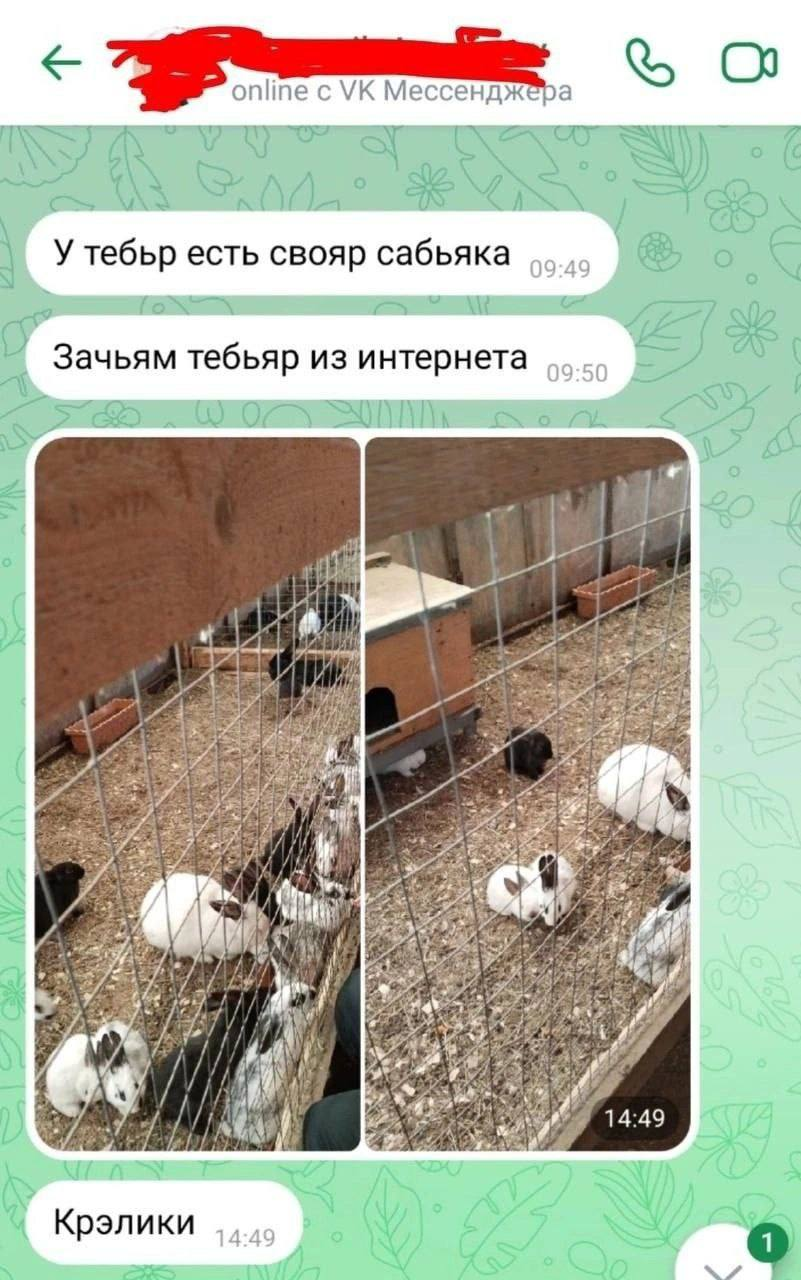